# Actor-critic algorithm 

The actor-critic algorithm is a model-free reinforcement learning algorithm. It shares some similarity with the Policy Iteration algorithm, as it maintains a model of the value function (the critic) and a model of the current policy (the actor), and it improves the actor based on the critic and vice versa. But, of course, the transition and reward functions are not known and updates are performed locally.

There are many possible implementations of an actor-critic algorithm. Here, we focus on the most naive one, where the actor is a stochastic policy and actor updates modify the probability of taking actions.


## Stochastic policy

By taking inspiration of the Policy Iteration algorithm given in the [dynamic programming](dynamic_programming.ipynb) notebook, write a class to handle a stochastic policy, which gives a probability of taking each action in each state
with a table $P[x,u]$.

In [ ]:
"write StochasticPolicy class here"

## Critic based on the action-value function

By taking inspiration of the Q-learning algorithm given in the [reinforcement learning](reinforcement_learning.ipynb) notebook, write a class to handle a critic represented as a Q-Table.

In [ ]:
"write the Q-table Critic class here"

## Actor-critic algorithm

Now, write the main ActorCritic class: it contains an agent, an actor, a critic, and two learning rate hyper-parameters $alpha_1$ and $alpha_2$.

Each time the agent takes a step in the environment, it computes a temporal difference error *delta* from the critic, then it updates the critic with

$Q[x,u] = Q[x,u] + alpha_1 * delta$

and it updates the probability of the actor of taking action *u* in state *x* with 

$P[x,u] = P[x,u] + alpha_2 * delta$

Then, it must renormalize the action probabilities for state *x*.

As for Q-learning and SARSA, the agent must perform some exploration steps, using for instance the softmax-policy or the *epsilon-greedy* policy, as seen in the [reinforcement learning](reinforcement_learning.ipynb) notebook.

In [20]:
"write your ActorCritic code here"
from dynamic_programming import *


class Agent():
    def __init__(self, mdp, lr1=0.1, lr2=0.1):
        self.mdp = mdp
        self.actor = Actor(self.mdp,lr1)
        self.critic = Critic(self.mdp,lr2)
        

    def learn(self,nEpisodes=10000,nTimesteps=50,test_conv=False):

        if(test_conv):
            [VI_Q_list, VI_policy_list] = VI_Q(mdp,render=False)
        
        Q_list = []
        policy_list = []

        # Run learning cycle
        mdp.timeout = nTimesteps #episode length
        
        nb_step=0
        conv= False

        for i in range(nEpisodes) :
            #Draw the first state of episode i using a uniform distribution over all the states
            x = mdp.reset(uniform=True) 
            done = mdp.done()
            while not done:
                nb_step+=1
                u = self.actor.choose_action(x)
                [y,r,done,info] = mdp.step(u)
                delta = self.critic.update(x,u,r,y)
                self.actor.update(x,u,r,y,delta)
                x = y
            
            policy = copy.deepcopy(self.actor.P)
            Q = copy.deepcopy(self.critic.Q)
            
            policy_list.append(self.actor)
            Q_list.append(self.critic)
            
            if(test_conv and not conv):
                if np.linalg.norm(Q-VI_Q_list[-1])<= 0.01 :
                    conv=True
                    print("Step to conv ", nb_step)
                    return [Q_list, policy_list]

        return [critic_list,actor_list]
        
        
class Actor():
    def __init__(self, mdp, lr=0.1, tau=1):
        self.P = np.zeros((mdp.observation_space.size,mdp.action_space.size))
        self.lr = lr
        self.tau = tau
        
    def update(self,x,u,r,y,delta):
        if x in mdp.terminal_states:
            self.P[x,u] = r
        else:
            #delta = r + mdp.gamma*np.max(self.P[y])-self.P[x,u]
            self.P[x,u] = self.P[x,u] + self.lr*delta
        
    def choose_action(self,x):
        return mdp.action_space.sample(prob_list=softmax(self.P,x,self.tau))
        
                          
class Critic():
    def __init__(self, mdp, lr=0.1):
        self.Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
        self.lr = lr
        
    def update(self,x,u,r,y):
        if x in mdp.terminal_states:
            delta = 0
            self.Q[x,u] = r
        else:
            delta = r + mdp.gamma*np.max(self.Q[y])-self.Q[x,u]
            self.Q[x,u] = self.Q[x,u] + self.lr*delta
        return delta
        

In [32]:
%matplotlib inline
from mdp import maze_mdp # Markov Decision Process
from maze_plotter import maze_plotter # used for visualization of the state value and policy evolution
import dynamic_programming as dp
import numpy as np
from toolbox import softmax
import copy


walls = [6,17,18,19]
height = 5
width = 5
mdp = maze_mdp(width, height, walls=walls, terminal_states=[height*width-1]) # maze-like MDP definition

agent = Agent(mdp,lr1=0.4,lr2=0.4)
critic_list, actor_list = agent.learn(nEpisodes=10000,nTimesteps=50,test_conv=True)

Step to conv  4654


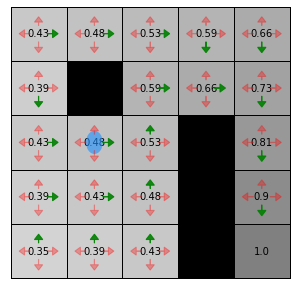

In [33]:
mdp.new_render()
mdp.render(actor_list[-1].P)

### Experiments

Play with the values of the hyper-parameters $alpha_1$ and $alpha_2$. Any idea how these hyper-parameters should be set with respect to each other?

## Critic based on the value function

The critic based on the action-value function can be replaced by a critic based on the value function without any change to the ActorCritic algorithm.

Try to do so below. Is it faster? Similar? Worse? In what case does it make a big difference?

In [ ]:
"write the V-based critic class here"

In [44]:
class Agent_V():
    def __init__(self, mdp, lr1=0.1, lr2=0.1):
        self.mdp = mdp
        self.actor = Actor(self.mdp,lr1)
        self.critic = Critic_V(self.mdp,lr2)
        

    def learn(self,nEpisodes=10000,nTimesteps=50,test_conv=False):

        if(test_conv):
            [VI_V_list, VI_policy_list] = VI_V(mdp,render=False)
            
        V_list = []
        policy_list = []
        
        nb_step=0
        conv= False

        # Run learning cycle
        mdp.timeout = nTimesteps #episode length

        for i in range(nEpisodes) :
            #Draw the first state of episode i using a uniform distribution over all the states
            x = mdp.reset(uniform=True) 
            done = mdp.done()
            while not done:
                nb_step+=1

                u = self.actor.choose_action(x)
                [y,r,done,info] = mdp.step(u)
                delta = self.critic.update(x,u,r,y)
                self.actor.update(x,u,r,y,delta)
                x = y
            
            policy = copy.deepcopy(self.actor.P)
            V = copy.deepcopy(self.critic.V)
            
            policy_list.append(self.actor)
            V_list.append(self.critic)
            
            if(test_conv and not conv):
                if np.linalg.norm(V-VI_V_list[-1])<= 0.01 :
                    conv=True
                    print("Step to conv ", nb_step)
                    return [V_list, policy_list]

        return [critic_list,actor_list]
        
                          
class Critic_V():
    def __init__(self, mdp, lr=0.1):
        self.V = np.zeros((mdp.observation_space.size))
        self.lr = lr
        
    def update(self,x,u,r,y):
        if x in mdp.terminal_states:
            delta = 0
            self.V[x] = r
        else:
            delta = r + mdp.gamma*self.V[y]-self.V[x]
            self.V[x] = self.V[x] + self.lr*delta
        return delta
        

In [45]:

walls = [6,17,18,19]
height = 5
width = 5
mdp = maze_mdp(width, height, walls=walls, terminal_states=[height*width-1]) # maze-like MDP definition

agent = Agent_V(mdp,lr1=0.1,lr2=0.2)
critic_list, actor_list = agent.learn(nEpisodes=10000,nTimesteps=50,test_conv=True)

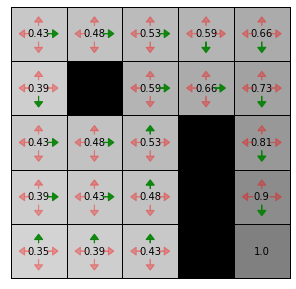

In [46]:
mdp.new_render()
mdp.render(actor_list[-1].P)